In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

fairuzazaria_rtm_stuck_prediction_dataframes_2_path = kagglehub.dataset_download('fairuzazaria/rtm-stuck-prediction-dataframes-2')

print('Data source import complete.')


# **DATA TRANSFORMATION**

In [ ]:
step_in   = 60
step_out  = 60
scaling   = False
well_name = "well_d"
scale_type = "no_scale"
use_additionals = True

if scaling:
    scale_type = "minmax"

In [ ]:
line_plot_conf = {
    "grid"     : True,
    "sharex"   : True,
    "figsize"  : (12, 16),
    "subplots" : True,
}

pie_plot_conf = {
    "autopct" : "%1.1f%%",
    "figsize" : (5, 5),
}

# **1. PREPARATION**

In [ ]:
!pip install fastparquet
!pip install pandas==2.2.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.9 MB/s eta 0:00:00a 0:00:01


## **1.1. IMPORT LIBRARIES**

In [ ]:
import os
import glob
import h5py
import pyarrow
import datetime
import fastparquet

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, skew, linregress

In [ ]:
from tqdm.notebook import tqdm
from multiprocessing import Lock

tqdm.set_lock(Lock())

## **1.2. PREPARE FUNCTIONS**

In [ ]:
#-- func: get all dataset directories
def get_dataset_directories(pattern: str = 'txt', dataset_type: str = 'old') -> tuple:
    working_dir = glob.glob(os.path.join(os.getcwd(), 'Datasets', '*'), recursive=True)
    dataset_dir = tuple(
        tuple(
            filename for filename in glob.iglob(os.path.join(dir, '**', f'*{pattern}'), recursive=True)
            if not filename.endswith(f'_pre_{dataset_type}.parquet')
        )
        for dir in working_dir
    )

    return (dataset_dir, working_dir)

In [ ]:
#-- func: check missing timestamps in dataset
def get_missing_timestamps(dataframe: pd.DataFrame, date_column: str, freq: str = '5s') -> tuple:
    missing = pd.date_range(
        start = dataframe[date_column].min(),
        end   = dataframe[date_column].max(),
        freq  = freq
    )

    return tuple(missing.difference(dataframe[date_column]))

In [ ]:
#-- func: apply sliding window
def split_sequences(sequences, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in tqdm(range(len(sequences))):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out

    if out_end_ix > len(sequences):
      break

    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[out_end_ix - 1, -1]
    X.append(seq_x)
    y.append(seq_y)

  return np.array(X), np.array(y)

In [ ]:
def vectorized_statistical_features(X):
    mins   = np.min(X, axis=2, keepdims=True)
    maxs   = np.max(X, axis=2, keepdims=True)
    ranges = maxs - mins

    X_2d = X.reshape(-1, X.shape[2])
    mask = ~np.all(X_2d == X_2d[:, [0]], axis=1)

    skew_vals = np.zeros(X_2d.shape[0])
    kurt_vals = np.zeros(X_2d.shape[0])
    skew_vals[mask] = skew(X_2d[mask], axis=1)
    kurt_vals[mask] = kurtosis(X_2d[mask], axis=1)

    diffs = np.diff(X, axis=2)
    stats = np.concatenate([
        mins, maxs,
        np.mean(X, axis=2, keepdims=True),
        np.std(X, axis=2, keepdims=True),
        np.median(X, axis=2, keepdims=True),
        skew_vals.reshape(X.shape[0], X.shape[1], 1),
        kurt_vals.reshape(X.shape[0], X.shape[1], 1),
        np.mean(diffs, axis=2, keepdims=True),
        np.std(diffs, axis=2, keepdims=True),
        np.min(diffs, axis=2, keepdims=True),
        np.max(diffs, axis=2, keepdims=True),
        ranges
    ], axis=2)

    return stats

In [ ]:
#-- func: remove placeholder values
def set_placeholder_value_to_nan(dataframe: pd.DataFrame, features: list, placeholder: str = '-') -> None:
    for feature in tqdm(features):
        dataframe[feature] = dataframe[feature].apply(lambda value: np.nan if value == placeholder else value)

In [ ]:
#-- func: scale every features
def feature_wise_minmax(X):
    num_samples, timesteps, num_features = X.shape
    X_scaled = np.zeros_like(X)

    scalers = []
    for i in range(num_features):
        scaler  = MinMaxScaler()
        feature = X[:, :, i].reshape(-1, 1)
        X_scaled[:, :, i] = scaler.fit_transform(feature).reshape(num_samples, timesteps)

        scalers.append(scaler)

    return X_scaled, scalers

In [ ]:
#-- func: transform every features
def feature_wise_minmax_transform(X, scalers):
    num_samples, timesteps, num_features = X.shape
    X_scaled = np.zeros_like(X)

    for i in range(num_features):
        feature = X[:, :, i].reshape(-1, 1)
        X_scaled[:, :, i] = scalers[i].transform(feature).reshape(num_samples, timesteps)

    return X_scaled

# **2. PREPROCESS DATA**

## **2.1. READ DATASET**

In [ ]:
#-- read dataset
ph = f'/kaggle/input/rtm-stuck-prediction-dataframes-2/{well_name}.parquet'
df = pq.read_table(ph).to_pandas()
df = df.rename(columns={
    "dt"        : "Date-Time",
    "md"        : "LogDepth",
    "bitdepth"  : "BitDepth",
    "blockpos"  : "BlockPos",
    "hklda"     : "Hkld",
    "mudflowin" : "MudFlowIn",
    "rop"       : "ROPi",
    "rpm"       : "RPM",
    "torqa"     : "Torque",
    "stppress"  : "SpPress",
    "woba"      : "WOB",
    "stuck"     : "Stuck"
})

print(f'fetched {well_name} data with shape {df.shape}')

fetched well_d data with shape (525956, 12)


In [ ]:
#-- define unused feature
features = [
    "Date-Time", "LogDepth",
    "BitDepth", "BlockPos",
    "Hkld", "MudFlowIn",
    "ROPi", "RPM",
    "Torque", "SpPress",
    "WOB", "Stuck"
]

df = df[features]

In [ ]:
#-- convert string datetime to datetime
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df = df.sort_values(by = ['Date-Time'])
df = df.reset_index(drop=True)

df.head()

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
0,2024-05-12 13:30:20,0.01,0.0,30.39,49.60,0.0,0.0,0.0,0.04,0.0,0.0,0.0
1,2024-05-12 13:30:25,0.01,0.0,30.39,49.52,0.0,0.0,0.0,0.02,0.0,0.0,0.0
2,2024-05-12 13:30:30,0.01,0.0,30.39,49.60,0.0,0.0,0.0,0.02,0.0,0.0,0.0
3,2024-05-12 13:30:35,0.01,0.0,30.39,49.52,0.0,0.0,0.0,0.02,0.0,0.0,0.0
4,2024-05-12 13:30:40,0.01,0.0,30.39,49.44,0.0,0.0,0.0,0.01,0.0,0.0,0.0


In [ ]:
#-- dataset info
print(f'{well_name} shape      : {df.shape}')
print(f"{well_name} labels     : {list(df['Stuck'].value_counts())}")
print(f'{well_name} missing    : {len(get_missing_timestamps(df, df.columns[0]))}')
print(f'{well_name} duplicates : {df["Date-Time"].duplicated().sum()}')
print(f'{well_name} nan values : \n\n{df.isna().sum()}\n')

well_d shape      : (525956, 12)
well_d labels     : [519168, 6788]
well_d missing    : 0
well_d duplicates : 0
well_d nan values : 

Date-Time    0
LogDepth     0
BitDepth     0
BlockPos     0
Hkld         0
MudFlowIn    0
ROPi         0
RPM          0
Torque       0
SpPress      0
WOB          0
Stuck        0
dtype: int64



In [ ]:
#-- start evenly
first_row  = df.iloc[0].copy()
first_rows = []

for i in range(4, 0, -1):
    new_row = first_row.copy()
    new_row['Date-Time'] = new_row['Date-Time'] - pd.Timedelta(seconds=5 * i)
    first_rows.append(new_row)

df = pd.concat([pd.DataFrame(first_rows), df], ignore_index=True)
df.head()

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
0,2024-05-12 13:30:00,0.01,0.0,30.39,49.6,0.0,0.0,0.0,0.04,0.0,0.0,0.0
1,2024-05-12 13:30:05,0.01,0.0,30.39,49.6,0.0,0.0,0.0,0.04,0.0,0.0,0.0
2,2024-05-12 13:30:10,0.01,0.0,30.39,49.6,0.0,0.0,0.0,0.04,0.0,0.0,0.0
3,2024-05-12 13:30:15,0.01,0.0,30.39,49.6,0.0,0.0,0.0,0.04,0.0,0.0,0.0
4,2024-05-12 13:30:20,0.01,0.0,30.39,49.6,0.0,0.0,0.0,0.04,0.0,0.0,0.0


In [ ]:
#-- dataset info
print(f'{well_name} shape      : {df.shape}')
print(f"{well_name} labels     : {list(df['Stuck'].value_counts())}")
print(f'{well_name} missing    : {len(get_missing_timestamps(df, df.columns[0]))}')
print(f'{well_name} duplicates : {df["Date-Time"].duplicated().sum()}')
print(f'{well_name} nan values : \n\n{df.isna().sum()}\n')
print(f'{well_name} negatives  : \n\n{(df[df.columns[1:-1]] < 0).sum()}\n')

well_d shape      : (525960, 12)
well_d labels     : [519172, 6788]
well_d missing    : 0
well_d duplicates : 0
well_d nan values : 

Date-Time    0
LogDepth     0
BitDepth     0
BlockPos     0
Hkld         0
MudFlowIn    0
ROPi         0
RPM          0
Torque       0
SpPress      0
WOB          0
Stuck        0
dtype: int64

well_d negatives  : 

LogDepth     0
BitDepth     0
BlockPos     0
Hkld         0
MudFlowIn    0
ROPi         0
RPM          0
Torque       0
SpPress      0
WOB          0
dtype: int64



## **2.2. DATA ANALYSIS**

In [ ]:
#-- check each max data:
print(f'{well_name} maxs : \n{df[df.columns[1:-1]].max()}\n')
print(f'{well_name} mins : \n{df[df.columns[1:-1]].min()}\n')

well_d maxs : 
LogDepth     1753.10
BitDepth     1751.53
BlockPos       34.57
Hkld          358.60
MudFlowIn    3777.33
ROPi         1800.00
RPM            64.00
Torque         28.58
SpPress      2615.19
WOB           105.74
dtype: float64

well_d mins : 
LogDepth     0.01
BitDepth     0.00
BlockPos     0.00
Hkld         0.00
MudFlowIn    0.00
ROPi         0.00
RPM          0.00
Torque       0.00
SpPress      0.00
WOB          0.00
dtype: float64



In [ ]:
#-- check unusual MudFlowIn values
df[df["MudFlowIn"] > 3000]

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
167976,2024-05-22 06:48:00,667.53,667.53,26.62,98.48,3102.87,6.36,40.0,8.18,1631.95,43.65,0.0
220534,2024-05-25 07:47:50,872.01,852.67,18.62,121.72,3694.87,11.25,23.0,3.71,1625.39,0.00,0.0
220538,2024-05-25 07:48:10,872.01,855.70,15.59,122.34,3243.61,11.25,23.0,3.92,1626.70,0.00,0.0
363081,2024-06-02 13:46:45,1145.65,1121.80,24.49,152.11,3777.33,10.98,30.0,6.52,1261.12,0.00,0.0
363082,2024-06-02 13:46:50,1145.65,1122.59,23.71,151.98,3649.92,10.98,30.0,6.41,1256.20,0.00,0.0
363083,2024-06-02 13:46:55,1145.65,1123.34,22.95,151.68,3577.75,10.98,30.0,6.60,1251.61,0.00,0.0
363084,2024-06-02 13:47:00,1145.65,1124.01,22.28,151.99,3515.74,10.98,30.0,6.67,1250.62,0.00,0.0
363085,2024-06-02 13:47:05,1145.65,1124.61,21.68,153.09,3487.55,10.98,30.0,6.92,1251.94,0.00,0.0
363086,2024-06-02 13:47:10,1145.65,1125.16,21.13,154.13,3459.36,10.98,30.0,7.48,1249.31,0.00,0.0
363087,2024-06-02 13:47:15,1145.65,1126.00,20.29,151.00,3459.36,10.98,30.0,6.53,1240.12,0.00,0.0


In [ ]:
#-- check error ropi values
df[(df["ROPi"] > 0) & (df["RPM"] == 0) & (df["Torque"] == 0)]

,Date-Time,LogDepth,BitDepth,BlockPos,Hkld,MudFlowIn,ROPi,RPM,Torque,SpPress,WOB,Stuck
8114,2024-05-13 00:46:10,28.01,27.76,8.07,39.30,0.0,15.52,0.0,0.0,0.0,0.0,0.0
8115,2024-05-13 00:46:15,28.01,27.76,8.07,39.23,0.0,15.52,0.0,0.0,0.0,0.0,0.0
8116,2024-05-13 00:46:20,28.01,27.76,8.07,39.37,0.0,15.52,0.0,0.0,0.0,0.0,0.0
8117,2024-05-13 00:46:25,28.01,27.76,8.07,39.37,0.0,15.52,0.0,0.0,0.0,0.0,0.0
8118,2024-05-13 00:46:30,28.01,27.76,8.07,39.37,0.0,15.52,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
525955,2024-06-11 23:59:35,1753.10,0.00,28.20,34.06,0.0,20.00,0.0,0.0,0.0,0.0,0.0
525956,2024-06-11 23:59:40,1753.10,0.00,28.20,34.06,0.0,20.00,0.0,0.0,0.0,0.0,0.0
525957,2024-06-11 23:59:45,1753.10,0.00,28.20,34.06,0.0,20.00,0.0,0.0,0.0,0.0,0.0
525958,2024-06-11 23:59:50,1753.10,0.00,28.20,34.06,0.0,20.00,0.0,0.0,0.0,0.0,0.0


## **2.3 HANDLE OUTLIERS**

In [ ]:
#-- replace ROPi outliers
df["ROPi"] = df.apply(lambda row: 0 if (
    row["ROPi"] > 0 and
    row["RPM"] == 0 and
    row["Torque"] == 0
) else row["ROPi"], axis=1)

In [ ]:
#-- replace MudFlowIn outliers
df["MudFlowIn"] = df["MudFlowIn"].apply(lambda value: np.nan if (value > 3000) else value)
df["MudFlowIn"] = df["MudFlowIn"].interpolate().ffill()

In [ ]:
#-- replace negative values with nan
for column in tqdm(df.columns[1:-1]):
    df[column] = df[column].apply(lambda value: np.nan if value < 0 else value)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#-- clip negatives
df[df.columns[1:-1]] = df[df.columns[1:-1]].clip(lower=0)

In [ ]:
#-- check each min max data:
print(f'{well_name} maxs : \n{df[df.columns[1:-1]].max()}\n')
print(f'{well_name} mins : \n{df[df.columns[1:-1]].min()}\n')

well_d maxs : 
LogDepth     1753.10
BitDepth     1751.53
BlockPos       34.57
Hkld          358.60
MudFlowIn    2617.08
ROPi         1800.00
RPM            64.00
Torque         28.58
SpPress      2615.19
WOB           105.74
dtype: float64

well_d mins : 
LogDepth     0.01
BitDepth     0.00
BlockPos     0.00
Hkld         0.00
MudFlowIn    0.00
ROPi         0.00
RPM          0.00
Torque       0.00
SpPress      0.00
WOB          0.00
dtype: float64



In [ ]:
#-- dataset info
print(f'{well_name} shape      : {df.shape}')
print(f"{well_name} labels     : {list(df['Stuck'].value_counts())}")
print(f'{well_name} missing    : {len(get_missing_timestamps(df, df.columns[0]))}')
print(f'{well_name} duplicates : {df["Date-Time"].duplicated().sum()}')
print(f'{well_name} nan values : \n\n{df.isna().sum()}\n')
print(f'{well_name} negatives  : \n\n{(df[df.columns[1:-1]] < 0).sum()}\n')

well_d shape      : (525960, 12)
well_d labels     : [519172, 6788]
well_d missing    : 0
well_d duplicates : 0
well_d nan values : 

Date-Time    0
LogDepth     0
BitDepth     0
BlockPos     0
Hkld         0
MudFlowIn    0
ROPi         0
RPM          0
Torque       0
SpPress      0
WOB          0
Stuck        0
dtype: int64

well_d negatives  : 

LogDepth     0
BitDepth     0
BlockPos     0
Hkld         0
MudFlowIn    0
ROPi         0
RPM          0
Torque       0
SpPress      0
WOB          0
dtype: int64



## **2.7. FEATURE EXTRACTION**

In [ ]:
#-- get differences
df["RpmDiff"]      = df["RPM"].diff().fillna(0)
df["HkldDiff"]     = df["Hkld"].diff().fillna(0)
df["TorqueDiff"]   = df["Torque"].diff().fillna(0)
df["BitDepthDiff"] = df["BitDepth"].diff().fillna(0)
df["LogDepthDiff"] = df["LogDepth"].diff().fillna(0)

In [ ]:
df["BitDepthRollMin"] = df["BitDepth"].rolling(180).min().fillna(0)
df["BitDepthRollMax"] = df["BitDepth"].rolling(180).max().fillna(0)

df["BitDepthRollMinDiff"] = df["BitDepthRollMin"].diff().fillna(0)
df["BitDepthRollMaxDiff"] = df["BitDepthRollMax"].diff().fillna(0)

df["HkldRollMin"] = df["Hkld"].rolling(180).min().fillna(0)
df["HkldRollMax"] = df["Hkld"].rolling(180).max().fillna(0)

In [ ]:
#-- check ROPi
miss_rop = len(df[(df["ROPi"] == 0) & (df["RPM"] > 0) & (df["Torque"] > 0) & (df["BitDepthDiff"] > 0) & (df["LogDepthDiff"] > 0)])
print(f"miscalculated ROPi: {miss_rop}")

miscalculated ROPi: 33


In [ ]:
#-- adjust ROPi
df["ROPi"] = df.apply(lambda row: 1e-6 if (
    row["ROPi"] == 0 and
    row["RPM"] > 0 and
    row["Torque"] > 0 and
    row["BitDepthDiff"] > 0 and
    row["LogDepthDiff"] > 0
) else row["ROPi"], axis=1)

In [ ]:
#-- check ROPi
miss_rop = len(df[(df["ROPi"] == 0) & (df["RPM"] > 0) & (df["Torque"] > 0) & (df["BitDepthDiff"] > 0) & (df["LogDepthDiff"] > 0)])
print(f"miscalculated ROPi: {miss_rop}")

miscalculated ROPi: 0


In [ ]:
#-- check bit location
df["BitInsideWell"] = df.apply(lambda row: 1 if (row["BitDepth"] != 0) else 0, axis=1)

In [ ]:
#-- check if unstable shell exist
df["ShellOnBitString"] = df.apply(lambda row: 1 if (
    (0 <= row["BitDepthRollMax"] - row["BitDepthRollMin"] <= 1) and
    row["RPM"] > 0 and
    row["Torque"] > 0
) else 0, axis=1)

In [ ]:
#-- check for bit drill
df["HIghForceNoRotation"] = df.apply(lambda row: 1 if (
    row["RPM"] == 0 and
    row["Torque"] > 0
) else 0, axis=1)

In [ ]:
#-- calculate drag
df["Drag"] = df.apply(lambda row: row["HkldDiff"] if (row["BitDepthDiff"] != 0) else 0, axis=1)
df["Drag"] = df.apply(lambda row: 0 if (row["Drag"] < 0) else row["Drag"], axis=1)

In [ ]:
#-- calculate overpull
df["Overpull"] = df.apply(lambda row: row["Hkld"] - row["HkldRollMin"] if (
    row["BitDepthDiff"] == 0 and
    row["Hkld"] > row["HkldRollMin"]
) else 0, axis=1)

In [ ]:
#-- check pump flow rate
df["PumpFlow"] = df.apply(lambda row: 1 if row["MudFlowIn"] != 0 else 0, axis=1)

In [ ]:
#-- check stall
df["Stall"] = df.apply(lambda row: 1 if (
    row["RPM"] == 0 and
    row["RpmDiff"] < 0 and
    row["TorqueDiff"] > 0
) else 0, axis=1)

In [ ]:
#-- check POOH and RIH
df["POOH"] = df.apply(lambda row: 1 if (
    row["BitDepthRollMinDiff"] < 0 and
    row["ROPi"] == 0 and
    row["WOB"] == 0 and
    row["LogDepthDiff"] == 0
) else 0, axis=1)

df["RIH"] = df.apply(lambda row: 1 if (
    row["BitDepthRollMaxDiff"] > 0 and
    row["ROPi"] == 0 and
    row["WOB"] == 0 and
    row["LogDepthDiff"] == 0
) else 0, axis=1)

In [ ]:
#-- check general activities
df["reaming"] = df.apply(lambda row: 1 if (
    row["RPM"] > 0 and
    row["WOB"] == 0 and
    row["ROPi"] == 0 and
    row["Torque"] > 0 and
    row["SpPress"] >= 0 and
    row["MudFlowIn"] > 0
) else 0, axis=1)

df["drilling"] = df.apply(lambda row: 1 if (
    row["WOB"] > 0 and
    row["RPM"] > 0 and
    row["ROPi"] > 0 and
    row["Torque"] >= 0 and
    row["LogDepthDiff"] > 0
) else 0, axis=1)

df["connection"] = df.apply(lambda row: 1 if (
    row["RPM"] == 0 and
    row["WOB"] == 0 and
    row["ROPi"] == 0 and
    row["LogDepthDiff"] == 0
) else 0, axis=1)

df["others"] = df.apply(lambda row: 1 if (
    row["reaming"] == 0 and
    row["drilling"] == 0 and
    row["connection"] == 0
) else 0, axis=1)

In [ ]:
#-- drop unused columns
df_stuck = df["Stuck"]
columns  = [
    "LogDepth",
    "BitDepth",
    "BlockPos",
    "BitDepthDiff",
    "LogDepthDiff",
    "HkldDiff",
    "RpmDiff",
    "TorqueDiff",
    "BitDepthRollMin",
    "BitDepthRollMax",
    "BitDepthRollMinDiff",
    "BitDepthRollMaxDiff",
    "HkldRollMin",
    "HkldRollMax",
    "Stuck"
]

df = df.drop(columns=columns)
df["Stuck"] = df_stuck

In [ ]:
#-- check activity overlapp
print(df.loc[(df["reaming"] == 1) & (df["drilling"] == 1)].shape)
print(df.loc[(df["reaming"] == 1) & (df["connection"] == 1)].shape)
print(df.loc[(df["connection"] == 1) & (df["drilling"] == 1)].shape)
print(df.loc[(df["connection"] == 1) & (df["reaming"] == 1)].shape)
print(df.loc[(df["drilling"] == 1) & (df["reaming"] == 1)].shape)
print(df.loc[(df["drilling"] == 1) & (df["connection"] == 1)].shape)

print(df.loc[(df["reaming"] == 1) & (df["drilling"] == 1) & (df["connection"] == 1)].shape)
print(df.loc[(df["reaming"] == 0) & (df["drilling"] == 0) & (df["connection"] == 0) & (df["others"] == 0)].shape)

(0, 22)
(0, 22)
(0, 22)
(0, 22)
(0, 22)
(0, 22)
(0, 22)
(0, 22)


In [ ]:
#-- dataset info
print(f'{well_name} shape      : {df.shape}')
print(f"{well_name} labels     : {list(df['Stuck'].value_counts())}")
print(f'{well_name} missing    : {len(get_missing_timestamps(df, df.columns[0]))}')
print(f'{well_name} duplicates : {df["Date-Time"].duplicated().sum()}')
print(f'{well_name} nan values : \n\n{df.isna().sum()}\n')
print(f'{well_name} negatives  : \n\n{(df[df.columns[1:-1]] < 0).sum()}\n')

well_d shape      : (525960, 22)
well_d labels     : [519172, 6788]
well_d missing    : 0
well_d duplicates : 0
well_d nan values : 

Date-Time              0
Hkld                   0
MudFlowIn              0
ROPi                   0
RPM                    0
Torque                 0
SpPress                0
WOB                    0
BitInsideWell          0
ShellOnBitString       0
HIghForceNoRotation    0
Drag                   0
Overpull               0
PumpFlow               0
Stall                  0
POOH                   0
RIH                    0
reaming                0
drilling               0
connection             0
others                 0
Stuck                  0
dtype: int64

well_d negatives  : 

Hkld                   0
MudFlowIn              0
ROPi                   0
RPM                    0
Torque                 0
SpPress                0
WOB                    0
BitInsideWell          0
ShellOnBitString       0
HIghForceNoRotation    0
Drag                   0
Overp

array([<Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>, <Axes: xlabel='Date-Time'>,
       <Axes: xlabel='Date-Time'>], dtype=object)

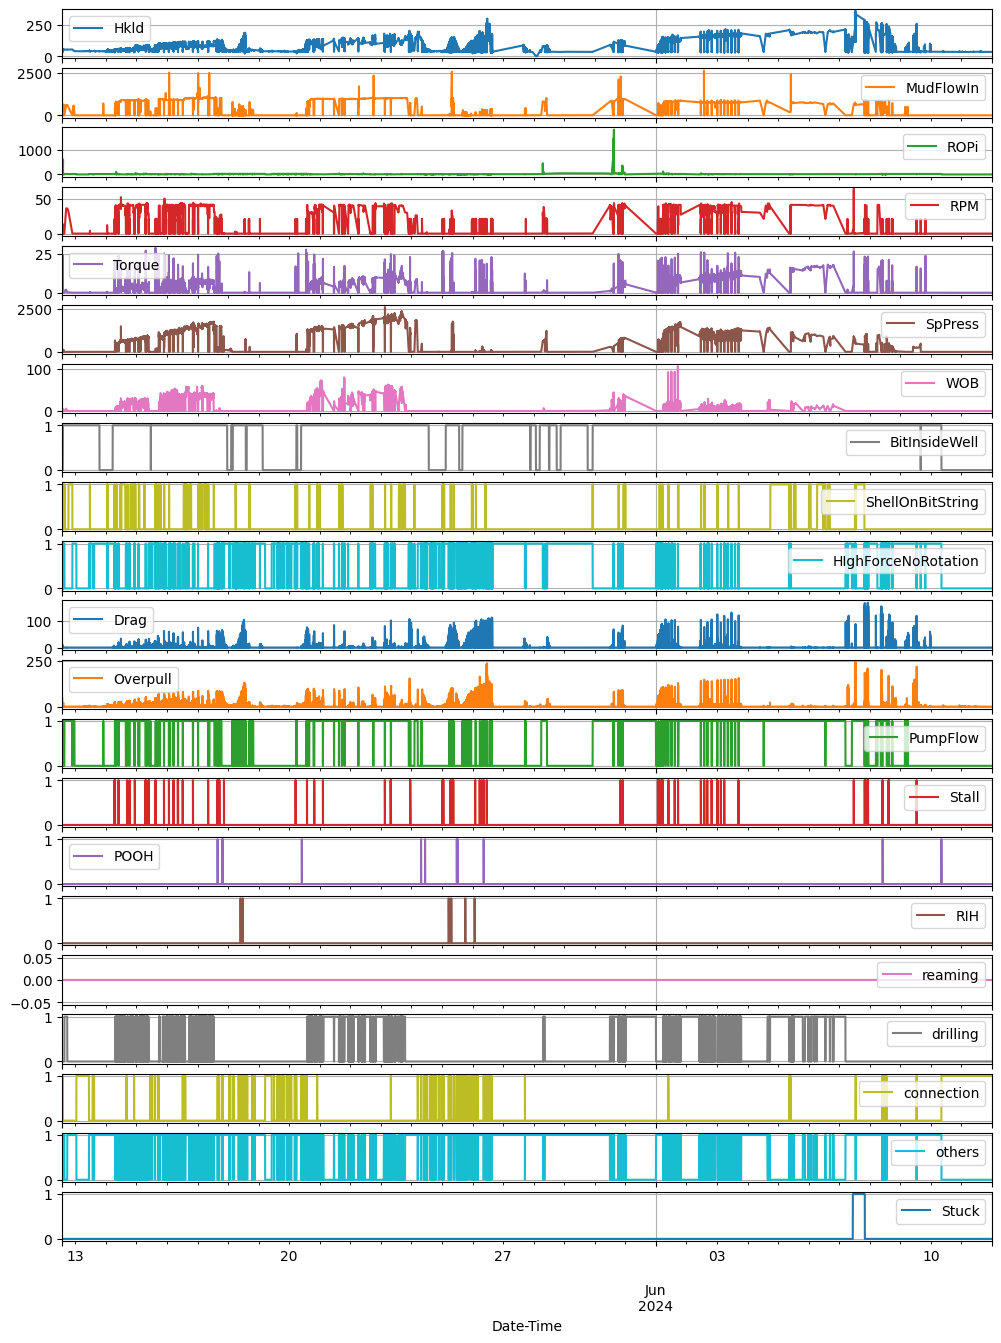

In [ ]:
df.set_index("Date-Time").plot(**line_plot_conf)

## **2.5. PROCESS DISTRUPTED TIMESERIES**

In [ ]:
#-- distrupted timesteps
distrupted = [
    (datetime.datetime(2024, 6, 7, 14, 30, 0), datetime.datetime(2024, 6, 7, 15, 0, 0)),
    (datetime.datetime(2024, 6, 7, 19, 0, 0), datetime.datetime(2024, 6, 7, 19, 30, 0))
]

In [ ]:
df = df.set_index("Date-Time")
for distrupt in tqdm(distrupted):
    df = df.loc[(df.index < distrupt[0]) | (df.index > distrupt[1])]

df = df.reset_index()

  0%|          | 0/2 [00:00<?, ?it/s]

## **2.6. APPLY SLIDING WINDOW**

In [ ]:
#-- differentiate features
num_features = df.columns[1:]
num_feature_con = [
    'Hkld', 'MudFlowIn',
    'ROPi', 'RPM', 'Torque',
    'SpPress', 'WOB', 'Drag',
    'Overpull', 'Stuck'
]

num_feature_cat = [
    'BitInsideWell', 'ShellOnBitString',
    'HIghForceNoRotation', 'PumpFlow',
    'Stall', 'POOH', 'RIH', 'reaming',
    'drilling', 'connection', 'others', 'Stuck'
]

In [ ]:
#-- apply sliding window
df_X_con = df.set_index("Date-Time")[num_feature_con].astype("float32").values
df_X_cat = df.set_index("Date-Time")[num_feature_cat].astype("float32").values

X_con, y_con = split_sequences(df_X_con, step_in, step_out)
X_cat, y_cat = split_sequences(df_X_cat, step_in, step_out)

  0%|          | 0/525238 [00:00<?, ?it/s]

  0%|          | 0/525238 [00:00<?, ?it/s]

In [ ]:
#-- get X shape
print(f'X_con : {X_con.shape}')
print(f'X_cat : {X_cat.shape}')
print(f'y_con : {y_con.shape}')
print(f'y_cat : {y_cat.shape}')

X_con : (525119, 60, 9)
X_cat : (525119, 60, 11)
y_con : (525119,)
y_cat : (525119,)


In [ ]:
split_point_con = int((len(df_X_con) - step_in + 1) * 0.857)
split_point_cat = int((len(df_X_cat) - step_in + 1) * 0.857)

In [ ]:
#-- split dataset
X_con_train, X_con_test = X_con[:split_point_con], X_con[split_point_con:]
y_con_train, y_con_test = y_con[:split_point_con], y_con[split_point_con:]
del X_con, y_con

X_cat_train, X_cat_test = X_cat[:split_point_cat], X_cat[split_point_cat:]
y_cat_train, y_cat_test = y_cat[:split_point_cat], y_cat[split_point_cat:]
del X_cat, y_cat

In [ ]:
print(f'continous shape : {X_con_train.shape, X_con_test.shape}')
print(f'static shape    : {X_cat_train.shape, X_cat_test.shape}')

continous shape : ((450078, 60, 9), (75041, 60, 9))
static shape    : ((450078, 60, 11), (75041, 60, 11))


In [ ]:
print(np.unique(y_con_train, return_counts=True))
print(np.unique(y_cat_train, return_counts=True))

(array([0., 1.], dtype=float32), array([447110,   2968]))
(array([0., 1.], dtype=float32), array([447110,   2968]))


In [ ]:
print(np.unique(y_con_test, return_counts=True))
print(np.unique(y_cat_test, return_counts=True))

(array([0., 1.], dtype=float32), array([71943,  3098]))
(array([0., 1.], dtype=float32), array([71943,  3098]))


## **2.7. SCALE DATASET**

In [ ]:
#-- scale dataset
if scaling:
    X_con_train, scalers = feature_wise_minmax(X_con_train)
    X_con_test = feature_wise_minmax_transform(X_con_test, scalers)

del y_cat_train, y_cat_test

In [ ]:
if use_additionals:
    X_train = np.concatenate([X_con_train, X_cat_train], axis=2)
    X_test  = np.concatenate([X_con_test, X_cat_test], axis=2)
    y_train = y_con_train
    y_test  = y_con_test
else:
    X_train = X_con_train
    X_test  = X_con_test
    y_train = y_con_train
    y_test  = y_con_test

In [ ]:
del X_con_train, X_cat_train, X_con_test, X_cat_test, y_con_train, y_con_test

In [ ]:
#-- get shapes
print(f'X_train : {X_train.shape}')
print(f'X_test  : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test  : {y_test.shape}')

X_train : (450078, 60, 20)
X_test  : (75041, 60, 20)
y_train : (450078,)
y_test  : (75041,)


# **3. SAVE DATASET**

In [ ]:
#-- get directories
train_path = os.path.join(os.getcwd(), f"{well_name}_train_adds_normal_{scale_type}_{step_in}{step_out}_0_new.h5")
test_path  = os.path.join(os.getcwd(), f"{well_name}_test_adds_normal_{scale_type}_{step_in}{step_out}_0_new.h5")

train_path, test_path

('/kaggle/working/well_d_train_adds_normal_no_scale_6060_0_new.h5',
 '/kaggle/working/well_d_test_adds_normal_no_scale_6060_0_new.h5')

In [ ]:
#-- save training data
n_samples, timesteps, features = X_train.shape
batch_size = 10000

with h5py.File(train_path, "w") as f:
    dset_X = f.create_dataset(
        "X", shape=(n_samples, timesteps, features),
        dtype="float32", compression="gzip", chunks=(batch_size, timesteps, features)
    )
    dset_y = f.create_dataset(
        "y", shape=(n_samples,),
        dtype="float16", compression="gzip", chunks=(batch_size,)
    )

    for i in range(0, n_samples, batch_size):
        end = min(i + batch_size, n_samples)

        X_batch = X_train[i:end]
        y_batch = y_train[i:end]

        dset_X[i:end] = X_batch
        dset_y[i:end] = y_batch

In [ ]:
#-- save test data
n_samples, timesteps, features = X_test.shape
batch_size = 1000

with h5py.File(test_path, "w") as f:
    dset_X = f.create_dataset(
        "X", shape=(n_samples, timesteps, features),
        dtype="float32", compression="gzip", chunks=(batch_size, timesteps, features)
    )
    dset_y = f.create_dataset(
        "y", shape=(n_samples,),
        dtype="float16", compression="gzip", chunks=(batch_size,)
    )

    for i in range(0, n_samples, batch_size):
        end = min(i + batch_size, n_samples)

        X_batch = X_test[i:end]
        y_batch = y_test[i:end]

        dset_X[i:end] = X_batch
        dset_y[i:end] = y_batch